# <b><u> Project Title : Traffic Jam: Predicting People's Movement into Nairobi </u></b>

## <b> Problem Description </b>

### This challenge asks you to build a model that predicts the number of seats that Mobiticket can expect to sell for each ride, i.e. for a specific route on a specific date and time. There are 14 routes in this dataset. All of the routes end in Nairobi and originate in towns to the North-West of Nairobi towards Lake Victoria.


### The towns from which these routes originate are:

* Awendo
* Homa Bay
* Kehancha
* Kendu Bay
* Keroka
* Keumbu
* Kijauri
* Kisii
* Mbita
* Migori
* Ndhiwa
* Nyachenge
* Oyugis
* Rodi
* Rongo
* Sirare
* Sori

### The routes from these 14 origins to the first stop in the outskirts of Nairobi takes approximately 8 to 9 hours from time of departure. From the first stop in the outskirts of Nairobi into the main bus terminal, where most passengers get off, in Central Business District, takes another 2 to 3 hours depending on traffic.

### The three stops that all these routes make in Nairobi (in order) are:

1. Kawangware: the first stop in the outskirts of Nairobi
2. Westlands
3. Afya Centre: the main bus terminal where most passengers disembark

### All of these points are mapped [here](https://www.google.com/maps/d/viewer?mid=1Ef2pFdP8keVHHid8bwju2raoRvjOGagN&ll=-0.8281897101491997%2C35.51706279999996&z=8).

### Passengers of these bus (or shuttle) rides are affected by Nairobi traffic not only during their ride into the city, but from there they must continue their journey to their final destination in Nairobi wherever that may be. Traffic can act as a deterrent for those who have the option to avoid buses that arrive in Nairobi during peak traffic hours. On the other hand, traffic may be an indication for people’s movement patterns, reflecting business hours, cultural events, political events, and holidays.

In [67]:
##importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [68]:
pd.set_option('display.max_columns', None)

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
dataset = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstons Projects/Supervised ML (Regression) - Capstone Project/train_revised.csv')

In [71]:
dataset.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [72]:
#Shape
dataset.shape

(51645, 10)

Since the target Variable is not provided, So we should have to generate it.

In [73]:
num_of_seats = dataset.groupby(['ride_id'])['seat_number'].count()

In [74]:
num_of_seats = num_of_seats.reset_index().rename(columns= {'seat_number': 'number_of_tickets'})

In [75]:
dataset = dataset.merge(num_of_seats, how='left', on='ride_id')

In [76]:
dataset.shape

(51645, 11)

Now our Data has 11 columns

In [77]:
#getting some information about the variables
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51645 entries, 0 to 51644
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ride_id            51645 non-null  int64 
 1   seat_number        51645 non-null  object
 2   payment_method     51645 non-null  object
 3   payment_receipt    51645 non-null  object
 4   travel_date        51645 non-null  object
 5   travel_time        51645 non-null  object
 6   travel_from        51645 non-null  object
 7   travel_to          51645 non-null  object
 8   car_type           51645 non-null  object
 9   max_capacity       51645 non-null  int64 
 10  number_of_tickets  51645 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.7+ MB


In [78]:
dataset.isna().sum()

ride_id              0
seat_number          0
payment_method       0
payment_receipt      0
travel_date          0
travel_time          0
travel_from          0
travel_to            0
car_type             0
max_capacity         0
number_of_tickets    0
dtype: int64

I remove 'payment_receipt' to find to find duplicated values

In [79]:
dataset = dataset.drop('payment_receipt', axis=1)

In [80]:
dataset.duplicated().sum()

169

In [81]:
dataset = dataset.drop_duplicates()

Since there are No null and duplicate Observations

####**Feature Engineering**

---

I generate two new varibles travel_day, travel_month to identify the traveling time on the monthaly & daily basses.
And i also convert traveling time in hours to minutes.


*   After creating travel_month and travel_day i drop travel_date.




In [82]:
dataset['travel_month'] = dataset['travel_date'].apply(lambda x: pd.Timestamp(x).month_name())

In [83]:
dataset['travel_day'] = dataset['travel_date'].apply(lambda x: pd.Timestamp(x).day_name())

In [84]:
def hr_to_min(x):
  date = pd.Timestamp(x)
  hm = date.hour*60
  min = date.minute
  total_min = hm + min
  return total_min

In [85]:
dataset['travel_time'] = dataset['travel_time'].apply(lambda x: hr_to_min(x))

In [86]:
dataset = dataset.drop(['travel_date'], axis=1)

In [87]:
dataset.head()

,ride_id,seat_number,payment_method,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_tickets,travel_month,travel_day
0,1442,15A,Mpesa,435,Migori,Nairobi,Bus,49,1,October,Tuesday
1,5437,14A,Mpesa,432,Migori,Nairobi,Bus,49,1,November,Sunday
2,5710,8B,Mpesa,425,Keroka,Nairobi,Bus,49,1,November,Sunday
3,5777,19A,Mpesa,430,Homa Bay,Nairobi,Bus,49,5,November,Monday
4,5778,11A,Mpesa,432,Migori,Nairobi,Bus,49,31,November,Monday


In [88]:
dataset['travel_time'] = dataset['travel_time'].apply(lambda x: 'Morning' if x < 720 else ('Afternoon' if x < 960 else 'Evening'))

#### description of the Data

In [89]:
dataset.describe(include='all')

,ride_id,seat_number,payment_method,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_tickets,travel_month,travel_day
count,51476.000000,51476,51476,51476,51476,51476,51476,51476.000000,51476.000000,51476,51476
unique,NaN,61,2,2,17,1,2,NaN,NaN,12,7
top,NaN,1,Mpesa,Morning,Kisii,Nairobi,Bus,NaN,NaN,December,Wednesday
freq,NaN,2064,51364,46623,22587,51476,31835,NaN,NaN,9498,8233
mean,10187.614655,NaN,NaN,NaN,NaN,NaN,NaN,34.500855,17.274011,NaN,NaN
std,2211.273736,NaN,NaN,NaN,NaN,NaN,NaN,18.459386,12.380067,NaN,NaN
min,1442.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,1.000000,NaN,NaN
25%,8280.750000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,9.000000,NaN,NaN
50%,10352.000000,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,11.000000,NaN,NaN
75%,12029.000000,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,26.000000,NaN,NaN


####Examin the Data Distribution of target Variable

In [90]:
target_var = dataset['number_of_tickets']

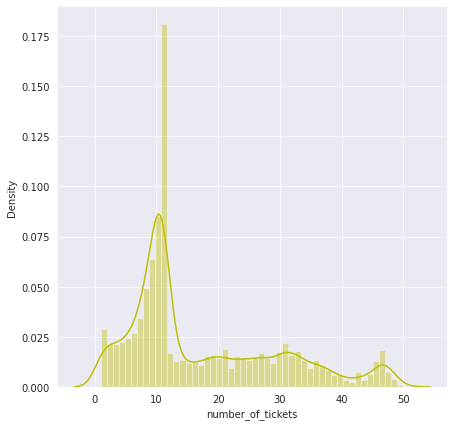

In [91]:
plt.figure(figsize=(7,7))
sns.distplot(target_var, color='y')
plt.show()

# Exploratory Data Analysis (EDA)

###First I perform EDA for **Numerical Variables**

In [92]:
numerical_feature = dataset.describe().columns
numerical_feature

Index(['ride_id', 'max_capacity', 'number_of_tickets'], dtype='object')

####Univariant Analysis

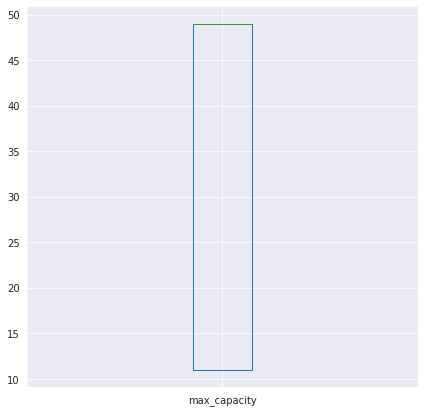

In [93]:
for col in numerical_feature[1:-1]:
  plt.figure(figsize=(7,7))
  dataset[col].plot(kind='box')
  

I draw a box plot of numerical variables to visualize the Outliers. Since there are no outliers.

Now I plot distplot of numerical Variables to see their data destribution.

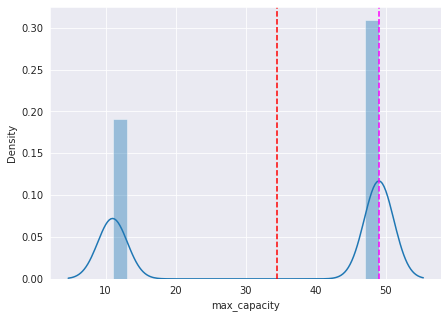

In [94]:
from pyparsing.helpers import LineStart
for col in numerical_feature[1:-1]:
  plt.figure(figsize = (7,5))
  sns.distplot(dataset[col])
  mean = dataset[col].mean()
  median = dataset[col].median()
  plt.axvline(mean, linestyle='--', color='red')
  plt.axvline(median, linestyle='--', color='magenta')

In [95]:
dataset['max_capacity'].unique()

array([49, 11])

since 'max_capacity' feature has only two unique values therefore we can consider it as a catagotical feature. 

###EDA For **Categorical Variabels**

In [96]:
categorical_features = dataset.describe(include = ['object', 'category']).columns
categorical_features = np.append(categorical_features, ['max_capacity'], axis=0)
categorical_features = np.delete(categorical_features, 2)
categorical_features

array(['seat_number', 'payment_method', 'travel_from', 'travel_to',
       'car_type', 'travel_month', 'travel_day', 'max_capacity'],
      dtype=object)

####Univarient Analysis

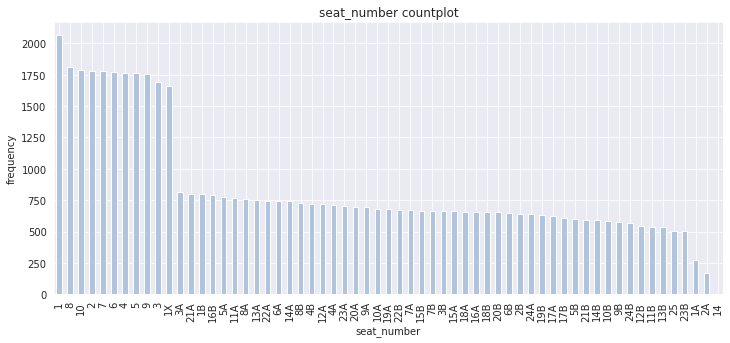

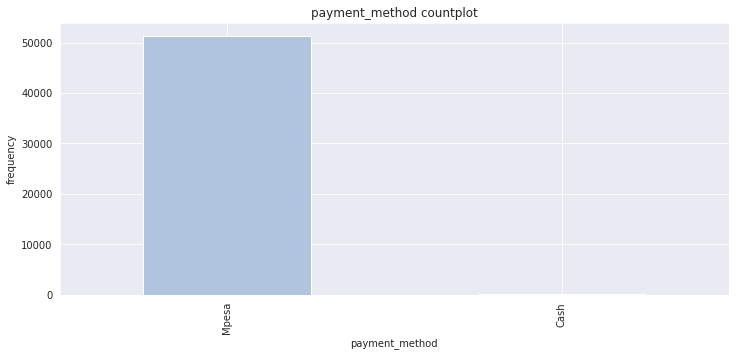

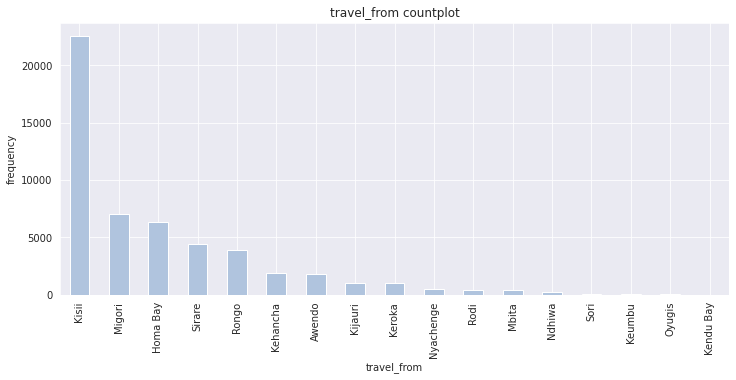

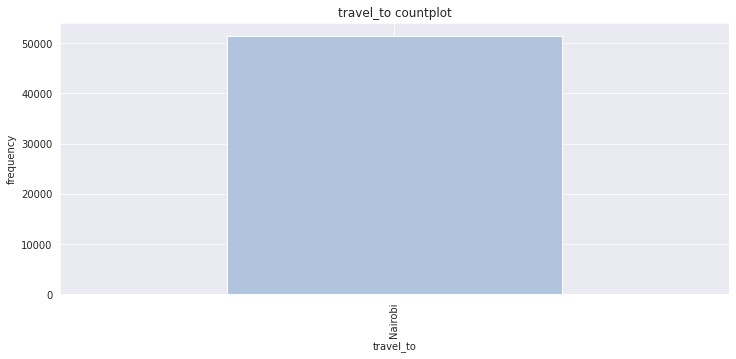

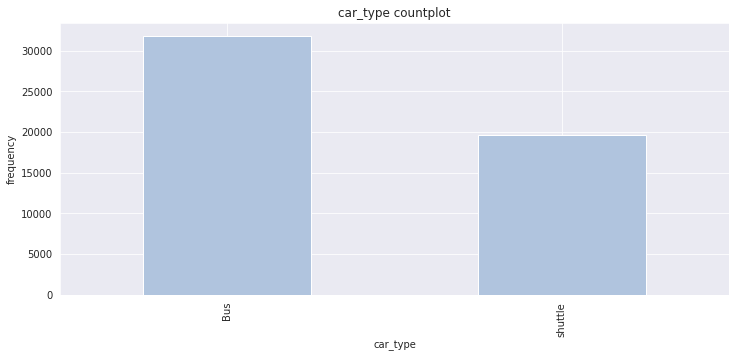

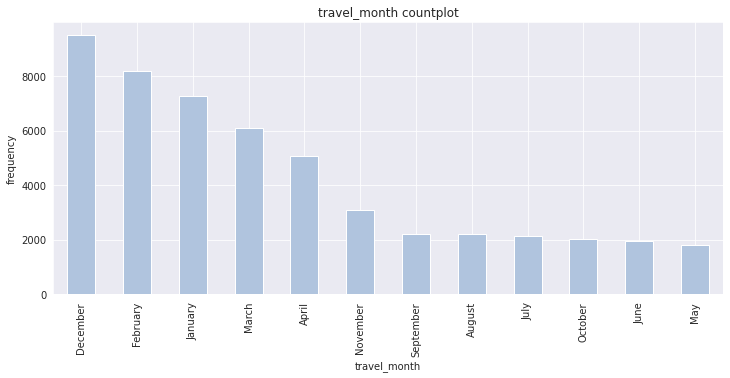

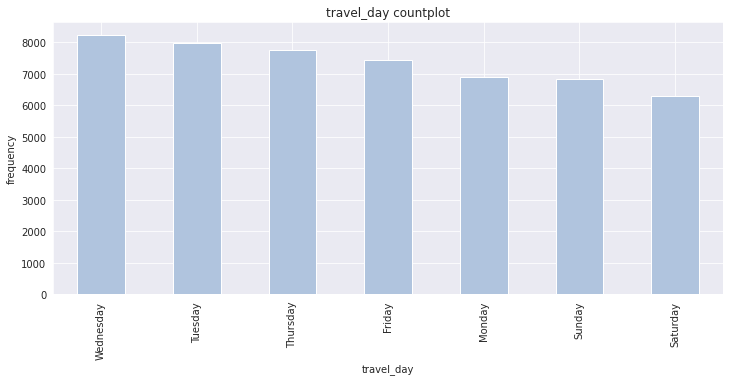

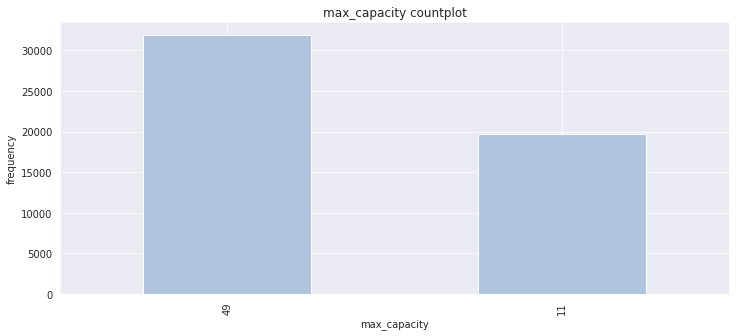

In [97]:
for col in categorical_features:
  count = dataset[col].value_counts()
  plt.figure(figsize = (12,5))
  count.plot(kind='bar', color='lightsteelblue')
  plt.xlabel(col)
  plt.ylabel('frequency')
  plt.title(f'{col} countplot')

plt.show()

from the above plots i comes to some conclusions:-


*   The route originat from kisii town has more movement as compare to other towns.

*   Movement of peoples are linear from May to september. and increase in the months from December to April
* The vehicle having 49 seats capacity are more in use as compare to vehicle having 11 seat capacity

* there is no ride is happining and the movment of peoples are more at morning as compaire Evening.


### Bivarient Analysis

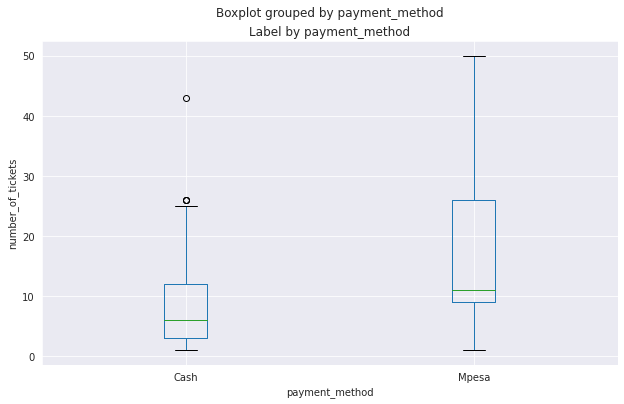

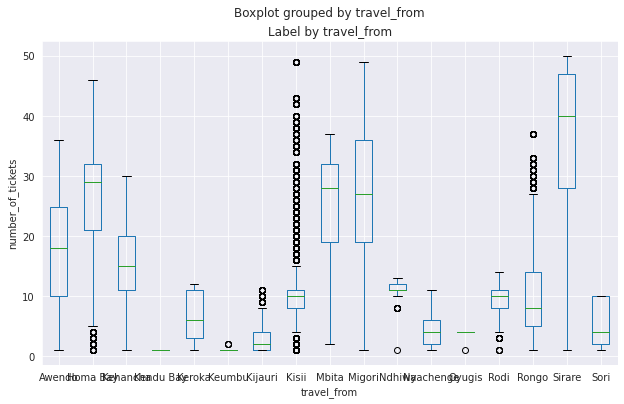

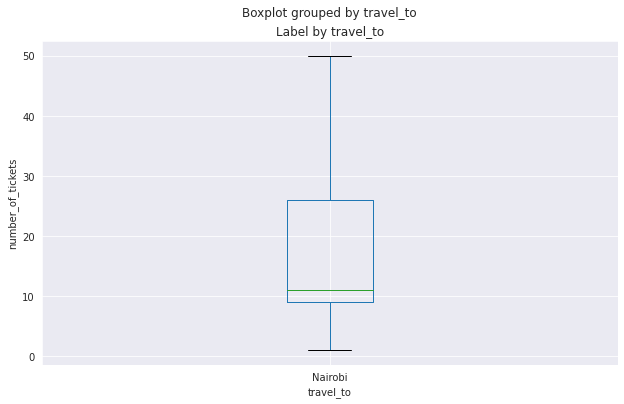

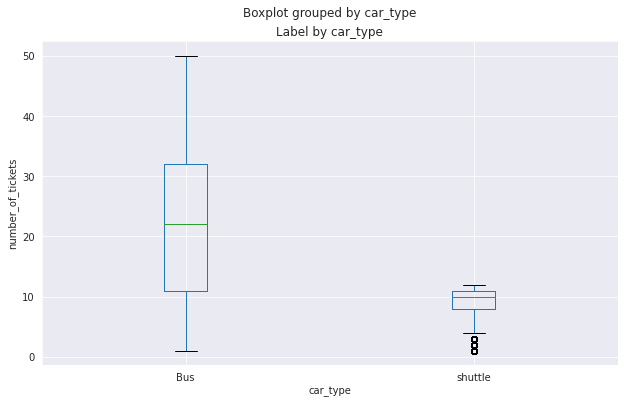

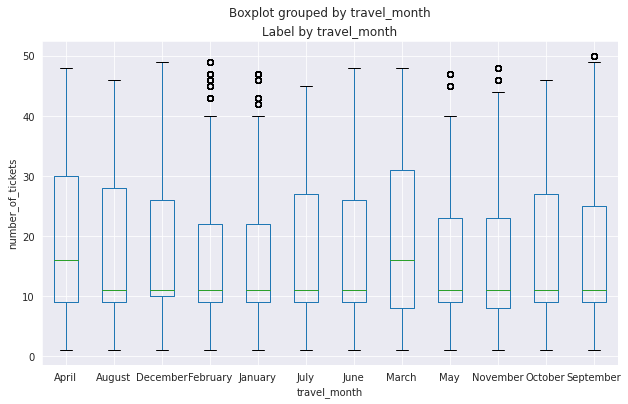

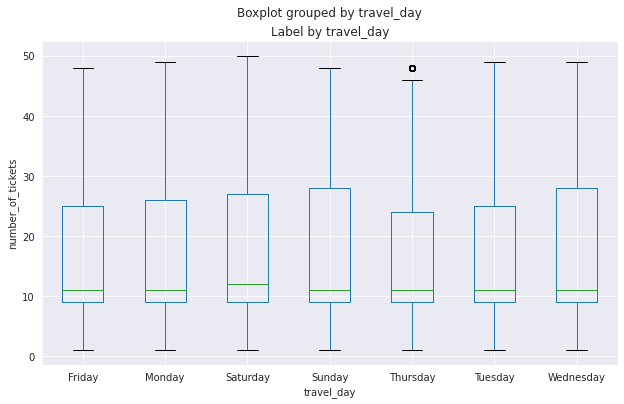

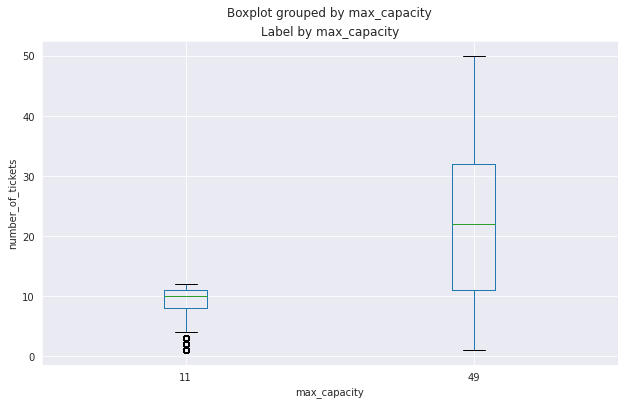

In [98]:
for col in categorical_features[1:]:
  fig = plt.figure(figsize = (10,6))
  ax = fig.gca()
  dataset.boxplot(column = 'number_of_tickets', by=col, ax = ax)
  ax.set_title('Label by ' + col)
  ax.set_ylabel('number_of_tickets')

plt.show()

what i get from above plots :-


*   More tickets are booked through Mpesa Payment Method.
*   tickets of buses are more booked as compaire shuttle.
* In March & April months more tickets are booked as compaire to other months.
* Booking of tickets are linear in all days of the weeks.
* As natural more capacity have more seats for booking, therefore 49 seats capacity vehicle have more booking as compare less capacity vehicle.
* Above we see that on bar plot the Morning Strength is more as compair to Evening but on box plot the number of tickets are more in Evening.
I thing it is becouse at morning time some peoples use train to reach their places on time. 




# Feature Engineering

In [99]:
df = dataset.copy()

In [100]:
#label encoding
encoding = {
    'payment_method' : {'Cash' : 0, 'Mpesa' : 1}, 
    'car_type': {'Bus': 0, 'shuttle' : 1},
    'travel_time': {'Morning' : 1, 'Evening': 0},
    'max_capacity' : {11 : 0, 49: 1}
}

df = df.replace(encoding)

In [101]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols= ['travel_from', 'travel_month', 'travel_day'], return_df= True)


In [103]:
df = encoder.fit_transform(df)

In [104]:
df.head()

,ride_id,seat_number,payment_method,travel_time,travel_from_0,travel_from_1,travel_from_2,travel_from_3,travel_from_4,travel_to,car_type,max_capacity,number_of_tickets,travel_month_0,travel_month_1,travel_month_2,travel_month_3,travel_day_0,travel_day_1,travel_day_2
0,1442,15A,1,1,0,0,0,0,1,Nairobi,0,1,1,0,0,0,1,0,0,1
1,5437,14A,1,1,0,0,0,0,1,Nairobi,0,1,1,0,0,1,0,0,1,0
2,5710,8B,1,1,0,0,0,1,0,Nairobi,0,1,1,0,0,1,0,0,1,0
3,5777,19A,1,1,0,0,0,1,1,Nairobi,0,1,5,0,0,1,0,0,1,1
4,5778,11A,1,1,0,0,0,0,1,Nairobi,0,1,31,0,0,1,0,0,1,1


**final features**

In [105]:
features_ = df.describe().columns
features_ = np.delete(features_, 0)
features_

Index(['payment_method', 'travel_time', 'travel_from_0', 'travel_from_1',
       'travel_from_2', 'travel_from_3', 'travel_from_4', 'car_type',
       'max_capacity', 'number_of_tickets', 'travel_month_0', 'travel_month_1',
       'travel_month_2', 'travel_month_3', 'travel_day_0', 'travel_day_1',
       'travel_day_2'],
      dtype='object')

In [106]:
df_pr = df[features_]

In [107]:
X = df_pr[np.delete(features_, 9) ]
Y = df_pr['number_of_tickets']

# Model Building

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state= 2)

In [110]:
print(X_train.shape)
print(X_test.shape)

(41180, 16)
(10296, 16)


##Linear Regression


---



In [111]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [112]:
linear_reg.score(X_train, y_train)

0.49642722614025325

In [113]:
lg_train_pred = linear_reg.predict(X_train)
lg_test_pred = linear_reg.predict(X_test)

In [114]:
def evaluate(given, predicted):
  MSE = mean_squared_error(given, predicted)
  RMSE = np.sqrt(mean_squared_error(given, predicted))

  RMSPE = (RMSE / np.mean(y_train))*100

  print('Mean Squre Error : ', MSE )

  print('Root Mean Squre Error : ', RMSE)
  print('Root Mean Squre Percentage Error : ', RMSPE)
  print('R2 Score : ', r2_score( given, predicted))

####Model Evalution

In [115]:
print('Train Dataset')
print('-------------')
evaluate(y_train, lg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, lg_test_pred)

Train Dataset
-------------
Mean Squre Error :  77.0502285982811
Root Mean Squre Error :  8.777825960810633
Root Mean Squre Percentage Error :  50.78050560754419
R2 Score :  0.49642722614025325
 
Test Dataset
-------------
Mean Squre Error :  76.74887502776993
Root Mean Squre Error :  8.76064352817588
Root Mean Squre Percentage Error :  50.68110370317108
R2 Score :  0.50254786892397


##Lasso Regression


---

In [116]:
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_reg = GridSearchCV(lasso, param_grid= parameters, scoring= 'neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [117]:
print("The best fit alpha value is found out to be :" ,lasso_reg.best_params_)
print("\nUsing ",lasso_reg.best_params_, " the negative mean squared error is: ", lasso_reg.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.0001}

Using  {'alpha': 0.0001}  the negative mean squared error is:  -77.15481895463952


In [118]:
lasso_train_pred = lasso_reg.predict(X_train)
lasso_test_pred = lasso_reg.predict(X_test)

####Model Evaluation

In [119]:
print('Train Dataset')
print('-------------')
evaluate(y_train, lasso_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, lasso_test_pred)

Train Dataset
-------------
Mean Squre Error :  77.04950118107209
Root Mean Squre Error :  8.777784525782806
Root Mean Squre Percentage Error :  50.78026590221485
R2 Score :  0.49643198027931756
 
Test Dataset
-------------
Mean Squre Error :  76.74843576688946
Root Mean Squre Error :  8.76061845801365
Root Mean Squre Percentage Error :  50.680958670047914
R2 Score :  0.5025507160179633


## Ridge Regression


---


In [120]:
from sklearn.linear_model import Ridge

In [121]:
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_reg = GridSearchCV(ridge, param_grid= parameters, scoring= 'neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [122]:
print("The best fit alpha value is found out to be :" ,ridge_reg.best_params_)
print("\nUsing ",ridge_reg.best_params_, " the negative mean squared error is: ", ridge_reg.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -77.15482002630415


In [123]:
ridge_train_pred = ridge_reg.predict(X_train)
ridge_test_pred = ridge_reg.predict(X_test)

Model Evaluation

In [124]:
print('Train Dataset')
print('-------------')
evaluate(y_train, ridge_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, ridge_test_pred)

Train Dataset
-------------
Mean Squre Error :  77.04952385569659
Root Mean Squre Error :  8.777785817374253
Root Mean Squre Percentage Error :  50.78027337418649
R2 Score :  0.49643183208607056
 
Test Dataset
-------------
Mean Squre Error :  76.74973799797085
Root Mean Squre Error :  8.760692780709231
Root Mean Squre Percentage Error :  50.68138863346672
R2 Score :  0.5025422755342903


## Decision Tree

In [141]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import graphviz

In [126]:
Dec_tree_reg = DecisionTreeRegressor(random_state=0)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["squared_error", "absolute_error"]
}

Dec_tree_reg = GridSearchCV(Dec_tree_reg, param_grid= params,
                            n_jobs=-1, verbose=1,
                            scoring='r2', cv = 4)

Dec_tree_reg.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='r2', verbose=1)

In [148]:
print("The best fit Parameters value are found out to be :" ,Dec_tree_reg.best_params_)
print("\nUsing ",Dec_tree_reg.best_params_, " the r2 Score is: ", Dec_tree_reg.best_score_)

The best fit Parameters value are found out to be : {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 5}

Using  {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 5}  the r2 Score is:  0.7168305433885935


Final Decision Tree

In [152]:
DecTree_reg = DecisionTreeRegressor(criterion= 'squared_error', max_depth = 20, min_samples_leaf =  5, random_state=0)

DecTree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=5, random_state=0)

In [157]:
DecTree_reg_train_pred = DecTree_reg.predict(X_train)
DecTree_reg_test_pred = DecTree_reg.predict(X_test)

In [158]:
print('Train Dataset')
print('-------------')
evaluate(y_train, DecTree_reg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, DecTree_reg_test_pred)

Train Dataset
-------------
Mean Squre Error :  41.06456204245174
Root Mean Squre Error :  6.4081637028443446
Root Mean Squre Percentage Error :  37.07179822192519
R2 Score :  0.7316166896419252
 
Test Dataset
-------------
Mean Squre Error :  41.2826910824922
Root Mean Squre Error :  6.425160782617988
Root Mean Squre Percentage Error :  37.17012784347509
R2 Score :  0.7324239261082511


**Visualization**

In [142]:
from IPython.display import SVG
from graphviz import Source

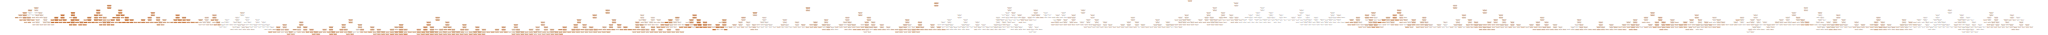

In [155]:
graph = Source(tree.export_graphviz(DecTree_reg, out_file=None
   , feature_names=X_train.columns , filled = True))
display(SVG(graph.pipe(format='svg')))


## RandomForest 

In [159]:
from sklearn.ensemble import RandomForestRegressor

In [160]:
rd_forest_reg = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50,100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50],
}

rd_forest_reg = GridSearchCV(rd_forest_reg, param_grid= param_grid, scoring='r2', cv = 4)
rd_forest_reg.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [161]:
print(f'The best Perameters Value are : {rd_forest_reg.best_params_}')
print(f'Bu Using : {rd_forest_reg.best_params_} the r2 Score is : {rd_forest_reg.best_score_}')

The best Perameters Value are : {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 150}
Bu Using : {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 150} the r2 Score is : 0.7181113341362999


Final Random Forest Tree 

In [162]:
RD_forest = RandomForestRegressor(n_estimators= 150, criterion='squared_error', max_depth=20, min_samples_leaf= 5)

RD_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=150)

In [164]:
RD_forest_train_pred = RD_forest.predict(X_train)
RD_forest_test_pred = RD_forest.predict(X_test)

In [165]:
print('Train Dataset')
print('-------------')
evaluate(y_train, RD_forest_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, RD_forest_test_pred)

Train Dataset
-------------
Mean Squre Error :  41.39755430072312
Root Mean Squre Error :  6.434093121856655
Root Mean Squre Percentage Error :  37.221802222167796
R2 Score :  0.7294403711776958
 
Test Dataset
-------------
Mean Squre Error :  41.55815127372062
Root Mean Squre Error :  6.4465611975471555
Root Mean Squre Percentage Error :  37.293931151397366
R2 Score :  0.730638515454302
